# Fitting and Interpolation Problems

Demonstrating some fitting and interpolation techniques described in [Steven Boyd's _convex optimization_ book](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf) §6.5.3, pp. 331-333

1. Generate $m$ data points $(u_1, y_1), \ldots , (u_m, y_m)$ at random in the interval $[0, 1]$.
2. Formulate and solve the convex optimization problem.
3. Plot the data and the interpolating function.

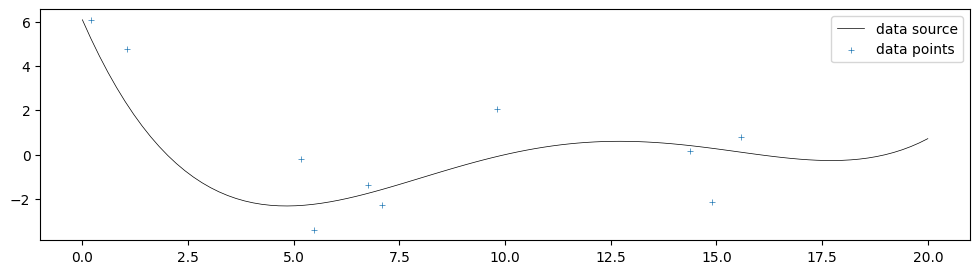

In [15]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Generate m data points
m = 10
u_min, u_max = 0, 20
u_length = u_max - u_min
u = u_length * np.random.rand(m)

min_freq, max_freq = 3, 6
coeffs = np.random.rand(2, max_freq)
f = lambda v: .001 * ( v - 2 ) * ( v - 10 ) * ( v - 16 ) * ( v - 19 )
y_true = f(u)

# min_freq, max_freq = 3, 6
# coeffs = np.random.rand(2, max_freq)
# f = lambda v: np.sum([
#     2 / k * coeffs[0, k] * np.sin(2 * k * np.pi * v / u_length) 
#     for k in range(min_freq, max_freq)
# ], axis=0) + np.sum([
#     2 / k * coeffs[1, k] * np.cos(2 * k * np.pi * v / u_length) 
#     for k in range(min_freq, max_freq)
# ], axis=0)
# y_true = f(u)

# noise_amplitude = .5
# noise = noise_amplitude * np.max(np.abs(y_true)) * np.random.randn(m)
# y = y_true + noise

noise_amplitude = .5
noise = noise_amplitude * np.max(np.abs(y_true)) * np.random.randn(m)
y = y_true + noise

v = np.linspace(u_min, u_max, 100)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(v, f(v), linewidth=.5, color='black', label='data source')
ax.scatter(u, y, s=20, marker='+', linewidth=.5, label='data points')
ax.legend()
plt.show()

## Polynomial fits

### Polynomial fits of degree $d$ using different $p$-norms

Determine 
$$
f(v) = \sum_{j=0}^{d} x_j v^j
$$
such that 
$$
                x
\quad = \quad   \argmin \sum_{i=0}^{m-1} \vert f(u_i) - y_i \vert^p 
\quad = \quad   \argmin \Vert (u_i^j)_{ij} \cdot x - y \Vert_p
$$

In [16]:
d = 5
p_norms = [1, 2, 'inf']

vandermonde = lambda u: np.array([
    [ ui ** j for j in range(d+1) ]
    for ui in u
])

A = vandermonde(u)

fits = dict()

for p_norm in p_norms:
    x = cp.Variable(d+1)
    obj = cp.Minimize( cp.pnorm( A @ x - y, p=p_norm ) )
    problem = cp.Problem( obj )
    problem.solve(verbose=False)
    fits[p_norm] = x.value

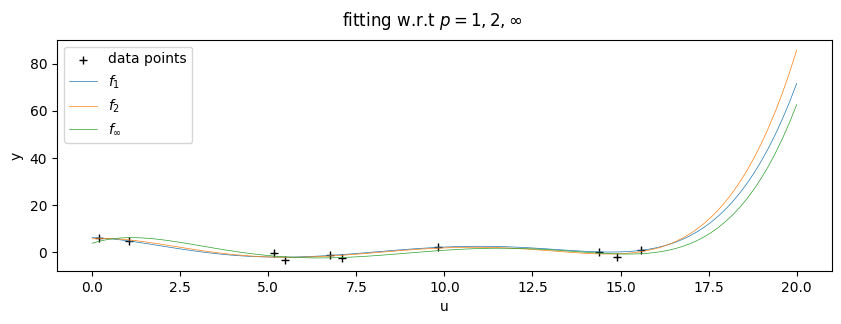

In [22]:
base_polynomials = vandermonde(v)

fig, ax = plt.subplots(figsize=(10,3))

tex_p_norms = [ "∞" if p == "inf" else str(p) for p in p_norms ]
fig.suptitle(f'fitting w.r.t $p = {", ".join(tex_p_norms)}$')

ax.set(
    xlabel='u',
    ylabel='y'
)
ax.scatter(u, y, color='black', s=40, marker='+', linewidth=1, label='data points')
for p_norm, tex in zip(p_norms, tex_p_norms):
    ax.plot(v, base_polynomials @ fits[p_norm], linewidth=.5, label=f'$f_{{{tex}}}$')
ax.legend()

plt.show()

### Imposing Constraints to control the Boundaries

The fits do not behave nicely near the boundaries $u_{\min}$ or $u_{\max}$. 
A first attempt to improve this is to require $f$ to be not too many standard deviations 
$\hat{\sigma}_{y}$ away from the mean $\hat{y}$ at the boundaries

$$
f(u_{\min}), f(u_{\max}) \in [\hat{y} - k\hat{\sigma}_{y}, \hat{y} + k\hat{\sigma}_{y}]
$$

which is in constraints expressed as follows

$$
                    \hat{y} - k \hat{\sigma}_{y}
\quad \leq \quad    \sum_{j=0}^{d} x_j u_{\texttt{<m>}}^j
\quad \leq \quad    \hat{y} + k \hat{\sigma}_{y}
\qquad              \text{ for }\texttt{<m>} = \min, \max
$$

In [18]:
y_hat, sigma_hat = np.mean(y), np.std(y)
k = 1.25
base_polynomial_boundaries = vandermonde([u_min, u_max])

boundary_constrained_fits = dict()

for p_norm in p_norms:
    x = cp.Variable(d+1)
    obj = cp.Minimize( cp.pnorm( A @ x - y, p=p_norm ) )
    constraints = [
        base_polynomial_boundaries @ x >= y_hat - k * sigma_hat,
        base_polynomial_boundaries @ x <= y_hat + k * sigma_hat
    ]
    problem = cp.Problem( obj, constraints )
    problem.solve(verbose=False)
    boundary_constrained_fits[p_norm] = x.value

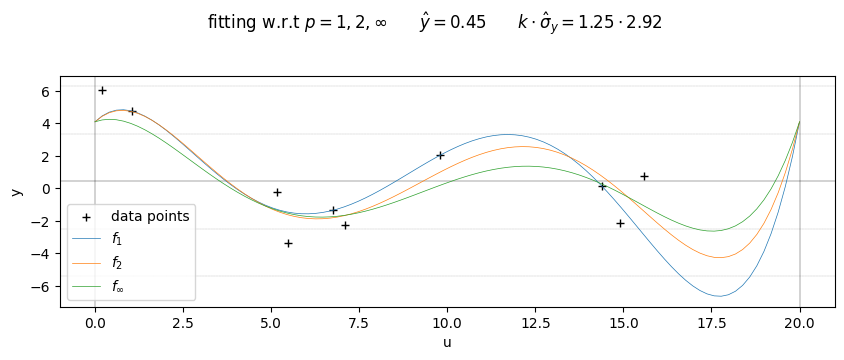

In [21]:
fig, ax = plt.subplots(figsize=(10,3))

fig.suptitle(
    f'fitting w.r.t $p = {", ".join(tex_p_norms)}$' \
    + f'      $\hat{{y}} = {np.round(y_hat, 2)}$' \
    + f'      $k \cdot \hat{{\sigma}}_{{y}} = {k} \cdot {np.round(sigma_hat, 2)}$',
    y=1.1
)

ax.set(
    xlabel='u',
    ylabel='y'
)
ax.axhline(y_hat, linewidth=.25, color='black')
ax.axvline(u_min, linewidth=.25, color='black')
ax.axvline(u_max, linewidth=.25, color='black')
for kk in range(int(k+1)):
    ax.axhline(y_hat - (kk+1) * sigma_hat, linewidth=.1, linestyle='dashed', color='black')
    ax.axhline(y_hat + (kk+1) * sigma_hat, linewidth=.1, linestyle='dashed', color='black')
ax.scatter(u, y, color='black', s=40, marker='+', linewidth=1, label='data points')
for p_norm, tex in zip(p_norms, tex_p_norms):
    ax.plot(v, base_polynomials @ boundary_constrained_fits[p_norm], linewidth=.5, label=f'$f_{{{tex}}}$')
ax.legend()

plt.show()

### Further Constraints near Boundaries

It is also possible to impose further constraints at $u$ near the boundaries $u_{\min} < u$ and $u < u_{\max}$.
This will reduce the spikes near the boundaries even further.

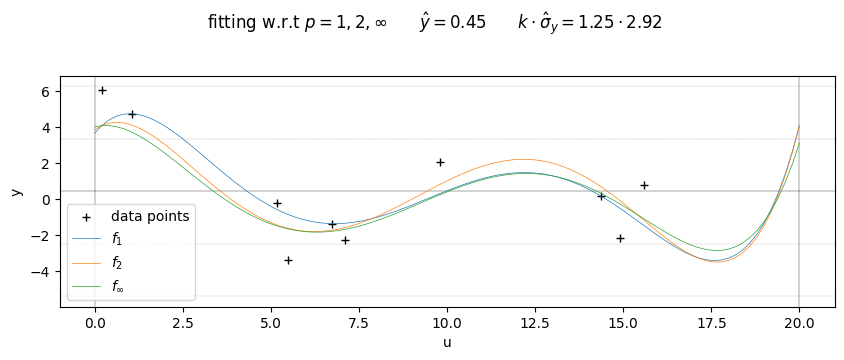

In [20]:
base_polynomial_left_boundary = vandermonde(np.linspace(u_min, np.min(u), 4))
base_polynomial_right_boundary = vandermonde(np.linspace(u_max, np.max(u), 4))

near_boundary_constrained_fits = dict()

for p_norm in p_norms:
    x = cp.Variable(d+1)
    obj = cp.Minimize( cp.pnorm( A @ x - y, p=p_norm ) )
    constraints = [
        base_polynomial_left_boundary @ x >= y_hat - k * sigma_hat,
        base_polynomial_left_boundary @ x <= y_hat + k * sigma_hat,
        base_polynomial_right_boundary @ x >= y_hat - k * sigma_hat,
        base_polynomial_right_boundary @ x <= y_hat + k * sigma_hat
    ]
    problem = cp.Problem( obj, constraints )
    problem.solve(verbose=False)
    near_boundary_constrained_fits[p_norm] = x.value

fig, ax = plt.subplots(figsize=(10,3))

fig.suptitle(
    f'fitting w.r.t $p = {", ".join(tex_p_norms)}$' \
    + f'      $\hat{{y}} = {np.round(y_hat, 2)}$' \
    + f'      $k \cdot \hat{{\sigma}}_{{y}} = {k} \cdot {np.round(sigma_hat, 2)}$',
    y=1.1
)

ax.set(
    xlabel='u',
    ylabel='y'
)
ax.axhline(y_hat, linewidth=.25, color='black')
ax.axvline(u_min, linewidth=.25, color='black')
ax.axvline(u_max, linewidth=.25, color='black')
for kk in range(int(k+1)):
    ax.axhline(y_hat - (kk+1) * sigma_hat, linewidth=.1, linestyle='dashed', color='black')
    ax.axhline(y_hat + (kk+1) * sigma_hat, linewidth=.1, linestyle='dashed', color='black')
ax.scatter(u, y, color='black', s=40, marker='+', linewidth=1, label='data points')
for p_norm, tex in zip(p_norms, tex_p_norms):
    ax.plot(v, base_polynomials @ near_boundary_constrained_fits[p_norm], linewidth=.5, label=f'$f_{{{tex}}}$')
ax.legend()

plt.show()